In [2]:
!pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 6.5 MB/s eta 0:00:00


In [3]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.autograd import Variable

import ot

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ot/backend.py:1368: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jax.device_put(jnp.array(1, dtype=jnp.float64), d)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [4]:
# Load in MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data
x_train = x_train/255.0
x_test = x_test/255.0

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
# Construct encoder and decoder networks
latent_length = 32

encoder = Sequential([
    Flatten(input_shape = (28, 28)),
    Dense(512),
    Dense(256),
    Dense(128),
    Dense(64),
    Dense(latent_length),
    LR()
])

decoder = Sequential([
    Dense(64, input_shape = (latent_length,)),
    Dense(128),
    Dense(256),
    Dense(512),
    Dense(784),
    Activation("sigmoid"),
    Reshape((28, 28))
])

In [7]:
# Load in pre-trained encoder-decoder networks
File = "encoder.pth"
encoder = torch.load(File)

File = "decoder.pth"
decoder = torch.load(File)

In [8]:
# Define branch and trunk networks to learn geodesics in encoded space
# Enhanced architecture

# Define network widths
m_b = 150 # branch width
m_t = 100 # trunk width

class Branch_enh(nn.Module):
    def __init__(self):
        super(Branch_enh, self).__init__()
        self.hidden_U = nn.Linear(32,m_b, bias=True)
        self.hidden_V = nn.Linear(32,m_b, bias=True)
        self.hidden_H_1 = nn.Linear(32,m_b, bias=True); self.hidden_Z_1 = nn.Linear(m_b,m_b, bias=True)
        self.hidden_Z_2 = nn.Linear(m_b,m_b, bias=True); self.hidden_Z_3 = nn.Linear(m_b,m_b, bias=True)
        self.hidden_Z_4 = nn.Linear(m_b,m_b, bias=True); self.hidden_Z_5 = nn.Linear(m_b,m_b, bias=True)
        self.hidden_Z_6 = nn.Linear(m_b,m_b, bias=True); self.hidden_Z_7 = nn.Linear(m_b,200, bias=True)


    def forward(self, u):
        U = F.tanh(self.hidden_U(u)); V = F.tanh(self.hidden_V(u)); H_1 = F.tanh(self.hidden_H_1(u));
        Z_1 = F.tanh(self.hidden_Z_1(H_1)); H_2 = (1 - Z_1)*U + Z_1*V
        Z_2 = F.tanh(self.hidden_Z_2(H_2)); H_3 = (1 - Z_2)*U + Z_2*V
        Z_3 = F.tanh(self.hidden_Z_3(H_3)); H_4 = (1 - Z_3)*U + Z_3*V
        Z_4 = F.tanh(self.hidden_Z_4(H_4)); H_5 = (1 - Z_4)*U + Z_4*V
        Z_5 = F.tanh(self.hidden_Z_5(H_5)); H_6 = (1 - Z_5)*U + Z_5*V
        Z_6 = F.tanh(self.hidden_Z_6(H_6)); H_7 = (1 - Z_6)*U + Z_6*V
        Z_7 = self.hidden_Z_7(H_7)
        output = Z_7
        return output

class Trunk_enh(nn.Module):
    def __init__(self):
        super(Trunk_enh, self).__init__()
        self.hidden_U = nn.Linear(2,m_t, bias=True)
        self.hidden_V = nn.Linear(2,m_t, bias=True)
        self.hidden_H_1 = nn.Linear(2,m_t, bias=True); self.hidden_Z_1 = nn.Linear(m_t,m_t, bias=True)
        self.hidden_Z_2 = nn.Linear(m_t,m_t, bias=True); self.hidden_Z_3 = nn.Linear(m_t,m_t, bias=True)
        self.hidden_Z_4 = nn.Linear(m_t,m_t, bias=True); self.hidden_Z_5 = nn.Linear(m_t,m_t, bias=True)
        self.hidden_Z_6 = nn.Linear(m_t,m_t, bias=True); self.hidden_Z_7 = nn.Linear(m_t,200, bias=True)


    def forward(self, x,t):
        z = torch.cat((x,t),1)
        U = F.tanh(self.hidden_U(z)); V = F.tanh(self.hidden_V(z)); H_1 = F.tanh(self.hidden_H_1(z));
        Z_1 = F.tanh(self.hidden_Z_1(H_1)); H_2 = (1 - Z_1)*U + Z_1*V
        Z_2 = F.tanh(self.hidden_Z_2(H_2)); H_3 = (1 - Z_2)*U + Z_2*V
        Z_3 = F.tanh(self.hidden_Z_3(H_3)); H_4 = (1 - Z_3)*U + Z_3*V
        Z_4 = F.tanh(self.hidden_Z_4(H_4)); H_5 = (1 - Z_4)*U + Z_4*V
        Z_5 = F.tanh(self.hidden_Z_5(H_5)); H_6 = (1 - Z_5)*U + Z_5*V
        Z_6 = F.tanh(self.hidden_Z_6(H_6)); H_7 = (1 - Z_6)*U + Z_6*V
        Z_7 = self.hidden_Z_7(H_7)
        output = Z_7
        return output

In [9]:
# Construct networks
cty_branch0 = Branch_enh().to(device)
cty_branch1 = Branch_enh().to(device)
cty_trunk = Trunk_enh().to(device)

HJ_branch0 = Branch_enh().to(device)
HJ_branch1 = Branch_enh().to(device)
HJ_trunk = Trunk_enh().to(device)

In [10]:
# Load in the models
File = "Cty_branch0.pth"
cty_branch0.load_state_dict(torch.load(File))

File = "Cty_branch1.pth"
cty_branch1.load_state_dict(torch.load(File))

File = "Cty_trunk.pth"
cty_trunk.load_state_dict(torch.load(File))

File = "HJ_branch0.pth"
HJ_branch0.load_state_dict(torch.load(File))

File = "HJ_branch1.pth"
HJ_branch1.load_state_dict(torch.load(File))

File = "HJ_trunk.pth"
HJ_trunk.load_state_dict(torch.load(File))

<All keys matched successfully>

In [11]:
# Define loss functions
mse_cost_function = torch.nn.MSELoss()
l1_cost_function = torch.nn.L1Loss()

# Define optimizer (Adam)
optimizer = optim.Adam([
    {'params': cty_branch0.parameters()},
    {'params': cty_branch1.parameters()},
    {'params': cty_trunk.parameters()},
    {'params': HJ_branch0.parameters()},
    {'params': HJ_branch1.parameters()},
    {'params': HJ_trunk.parameters()},
], lr=2e-4)

In [12]:
# Construct training data from MNIST data

# Define parameters for training
N = 30000  # Number of initial conditions (total MNIST size / 2)
n = latent_length

# Initialize training data as numpy arrays
u0 = np.zeros(shape=(N,n))
u1 = np.zeros(shape=(N,n))

# Encode the MNIST data
encoded_train = encoder(x_train)

# Place the encoded data into the numpy arrays. Shift upwards by 10 to ensure nonnegativity for densities
for i in range(N):
  u0[i,:] = encoded_train[i,:].numpy() + 10
  u1[i,:] = encoded_train[i+N,:].numpy() + 10

# Store normalization coefficients to convert back from densities to encoded representations
normalization_constants = np.zeros(shape=(N,2))

x_min = 0 # Domain beginning
x_max = 5 # Domain endpoint
for i in range(N):

  # Collect normalization constant
  normalization_constants[i,0] = ((x_max-x_min)/n)*np.sum(u0[i,:])
  normalization_constants[i,1] = ((x_max-x_min)/n)*np.sum(u1[i,:])

  # Normalize the data to be made densities
  u0[i,:] /= ((x_max/n)*np.sum(u0[i,:]))
  u1[i,:] /= ((x_max/n)*np.sum(u1[i,:]))

# Convert training data to PyTorch tensors
u0 = Variable(torch.from_numpy(u0)).to(device)
u1 = Variable(torch.from_numpy(u1)).to(device)
u0 = u0.to(torch.float32)
u1 = u1.to(torch.float32)

In [13]:
# Define additional tensors used as input, notably space and time
X = torch.arange(x_min, x_max, (x_max-x_min)/n).to(device)
X_vec = torch.unsqueeze(X,1).to(device)
t0 = torch.zeros(size=(n,1)).to(device)
t1 = torch.ones(size=(n,1)).to(device)

In [ ]:
def physics_informed_loss(x, t, u0, u1, cty_branch0, cty_branch1, cty_trunk, HJ_branch0, HJ_branch1, HJ_trunk):

  # Define continuity outputs
  cty_branch0_output = cty_branch0(u0)
  cty_branch1_output = cty_branch1(u1)
  cty_trunk_output = cty_trunk(x, t)

  # Take continuity derivatives
  cty = torch.sum( (cty_branch0_output * cty_branch1_output) * cty_trunk_output, dim=1)
  cty_x = torch.autograd.grad(cty.sum(), x, create_graph=True)[0]
  cty_t = torch.autograd.grad(cty.sum(), t, create_graph=True)[0]
  cty = torch.unsqueeze(cty,1)

  # Define HJ outputs
  HJ_branch0_output = HJ_branch0(u0)
  HJ_branch1_output = HJ_branch1(u1)
  HJ_trunk_output = HJ_trunk(x, t)

  # Take HJ derivatives
  HJ = torch.sum( (HJ_branch0_output * HJ_branch1_output) * HJ_trunk_output, dim=1)
  HJ_x = torch.autograd.grad(HJ.sum(), x, create_graph=True)[0]
  HJ_xx = torch.autograd.grad(HJ_x.sum(), x, create_graph=True)[0]
  HJ_t = torch.autograd.grad(HJ.sum(), t, create_graph=True)[0]
  HJ = torch.unsqueeze(HJ,1)

  # Construct physics-informed loss
  cty_loss = (cty_t + cty_x*HJ_x + cty*HJ_xx)**2
  HJ_loss = (HJ_t + (1/2)*(HJ_x**2))**2

  return(cty_loss + HJ_loss)

In [ ]:
# Training hyperparameters
num_iter = 300000
batch_size = 1000

# Initialize zero vector for physics-informed loss
T0 = torch.zeros(size=(batch_size,1)).to(device)

# Training algorithm
for i in range(num_iter):

  # Define random indices for input
  I =  np.random.randint(0,N,batch_size)
  J = np.random.randint(0,n,batch_size)

  # Collocation procedure : randomly sample x and t
  x_unif = Variable(torch.from_numpy(np.random.uniform(x_min,x_max,size=(batch_size,1))).float(), requires_grad=True).to(device)
  t_unif = Variable(torch.from_numpy(np.random.uniform(0,1,size=(batch_size,1))).float(), requires_grad=True).to(device)

  # Define continuity outputs for boundary conditions
  cty_branch0_output = cty_branch0(u0[I,:])
  cty_branch1_output = cty_branch1(u1[I,:])
  cty_trunk_output_0 = cty_trunk(X_vec[J], t0[J])
  cty_trunk_output_1 = cty_trunk(X_vec[J], t1[J])

  # Evaluate continuity DeepONets
  inner_prod_0 = torch.sum( (cty_branch0_output * cty_branch1_output) * cty_trunk_output_0, dim=1)
  inner_prod_1 = torch.sum( (cty_branch0_output * cty_branch1_output) * cty_trunk_output_1, dim=1)

  # Take boundary loss
  boundary_loss_0 = mse_cost_function(inner_prod_0, u0[I,J])
  boundary_loss_1 = mse_cost_function(inner_prod_1, u1[I,J])

  # Compute physics-informed loss
  physics_term = physics_informed_loss(x_unif, t_unif, u0[I,:], u1[I,:], cty_branch0, cty_branch1, cty_trunk, HJ_branch0, HJ_branch1, HJ_trunk)
  physics_loss = l1_cost_function(physics_term, T0)

  # Compute loss
  loss = boundary_loss_0  + boundary_loss_1 + 1*physics_loss

  # Update parameter
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if i % 100 == 0:
    print("Training loss:", '{:.4e}'.format(loss.data), "- PINN loss:", '{:.4e}'.format(physics_loss))

In [ ]:
# Save the models to current directory
File = "Cty_branch0.pth"
torch.save(cty_branch0.state_dict(), File)

File = "Cty_branch1.pth"
torch.save(cty_branch1.state_dict(), File)

File = "Cty_trunk.pth"
torch.save(cty_trunk.state_dict(), File)

File = "HJ_branch0.pth"
torch.save(HJ_branch0.state_dict(), File)

File = "HJ_branch1.pth"
torch.save(HJ_branch1.state_dict(), File)

File = "HJ_trunk.pth"
torch.save(HJ_trunk.state_dict(), File)

In [14]:
# Define a heat map plot
def heatmap2d(data: np.ndarray):
  cmap = LinearSegmentedColormap.from_list('Colormap', [ 'orangered', 'darkorange', 'aquamarine', 'dodgerblue', 'blue'])
  fig, (ax) = plt.subplots(1,1, figsize=(6,4))
  ax = sns.heatmap(data, ax=ax, cmap=cmap, square=True, cbar=False)

  ax.set(xticklabels=[]); ax.set(yticklabels=[]); ax.tick_params(left=False, bottom=False)
  plt.savefig("heatmap.png", dpi=300)
  plt.show()

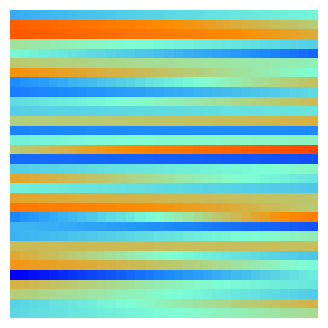

In [42]:
# Get sample test results
u_test = torch.zeros(size=(n,n))
I = np.random.randint(0,N,1)
J = np.random.randint(0,N,1)
for i in range(n):
  cty_branch0_output_test = cty_branch0(u0[I,:])
  cty_branch1_output_test = cty_branch1(u1[J,:])
  T_test = 1*(i/(n-1))*torch.ones(size=(n,1)).to(device)
  cty_trunk_output_test = cty_trunk(X_vec, T_test)
  u_test[:,i] = torch.sum( (cty_branch0_output_test * cty_branch1_output_test) * cty_trunk_output_test, dim=1)

heatmap2d(u_test.detach().numpy())

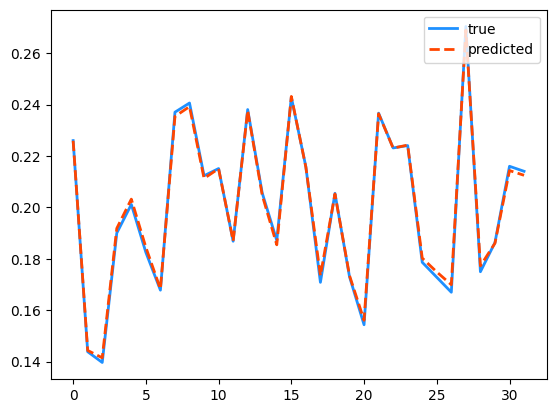

In [43]:
# Plot mu_0 initial condition
plt.plot(torch.squeeze(u0[I,:].cpu()), linewidth=2, color='dodgerblue')
plt.plot(u_test[:,0].cpu().detach().numpy(), linewidth=2, linestyle='dashed', color='orangered')
plt.legend(['true', 'predicted'], loc='upper right')
#plt.savefig("initial_condition.png", dpi=300)

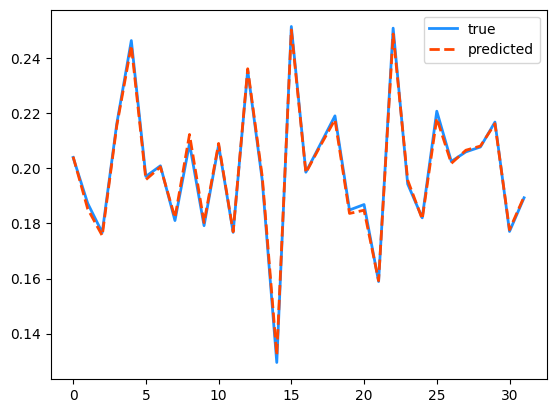

In [44]:
# Plot mu_1 initial condition
plt.plot(torch.squeeze(u1[J,:].cpu()), linewidth=2, color='dodgerblue')
plt.plot(u_test[:,n-1].cpu().detach().numpy(), linewidth=2, linestyle='dashed', color='orangered')
plt.legend(['true', 'predicted'], loc='upper right')
plt.savefig("initial_condition.png", dpi=300)

In [45]:
# Perform POT to find reference geodesic in encoded space
T = n

y = np.arange(n, dtype=np.float64)
OT = np.zeros(shape=(n,T))

a1 = u0[I,:].cpu()
a2 = u1[J,:].cpu()

A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]

K = ot.utils.dist0(n)
K /= K.max()

for t in range(T):
  alpha = t/(T-1)  # 0<=alpha<=1
  weights = np.array([1 - alpha, alpha])

  reg = 0.0003
  bary_wass = ot.bregman.barycenter(A, K, reg, weights)

  OT[:,t] = bary_wass

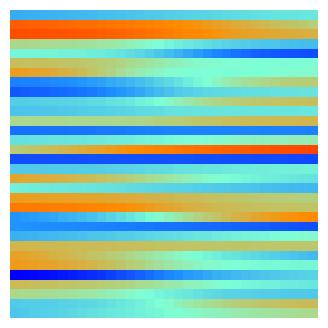

In [46]:
heatmap2d(OT)

In [47]:
# Compute L1 error between GeONet and POT
time_steps = 5
errors_encoded = np.zeros(shape=(1,time_steps))
for step in range(time_steps):
  i = max(step*8-1,0)
  errors_encoded[0,step] = np.sum( np.abs(u_test[:,i].detach().numpy() - OT[:,i]) ) / np.sum( OT[:,i])

  print("Time:", step/4, "- L1 error:", errors_encoded[0,step])

Time: 0.0 - L1 error: 0.01335374273812795
Time: 0.25 - L1 error: 0.013824257360718552
Time: 0.5 - L1 error: 0.016684805622832338
Time: 0.75 - L1 error: 0.016572366607701533
Time: 1.0 - L1 error: 0.014879891143763379


In [48]:
# Define heatmap grid
def heatmap2d_grid(u: np.ndarray):
  cmap = 'gray'

# Plot the geodesics at the five times
  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(12,6))

  ax1 = sns.heatmap(u[0,:,:], ax=ax1, cmap=cmap, square=True, cbar=False)
  ax1.set(xticklabels=[]); ax1.set(yticklabels=[]); ax1.tick_params(left=False, bottom=False)

  ax2 = sns.heatmap(u[1,:,:], ax=ax2, cmap=cmap, square=True, cbar=False)
  ax2.set(xticklabels=[]); ax2.set(yticklabels=[]); ax2.tick_params(left=False, bottom=False)

  ax3 = sns.heatmap(u[2,:,:], ax=ax3, cmap=cmap, square=True, cbar=False)
  ax3.set(xticklabels=[]); ax3.set(yticklabels=[]); ax3.tick_params(left=False, bottom=False)

  ax4 = sns.heatmap(u[3,:,:], ax=ax4, cmap=cmap, square=True, cbar=False)
  ax4.set(xticklabels=[]); ax4.set(yticklabels=[]); ax4.tick_params(left=False, bottom=False)

  ax5 = sns.heatmap(u[4,:,:], ax=ax5, cmap=cmap, square=True, cbar=False)
  ax5.set(xticklabels=[]); ax5.set(yticklabels=[]); ax5.tick_params(left=False, bottom=False)

  plt.savefig('Pred_geodesic.png', dpi=350)

  plt.xticks([])
  plt.yticks([])
  plt.show()

In [52]:
# Decode solution
time_steps = 5
u_test_decoded = np.zeros(shape=(5,28,28))
for step in range(time_steps):
  i = max(step*8-1,0)
  u_encoded_section = u_test[:,i].cpu().detach().numpy().squeeze() * (normalization_constants[I,0]*(1 - step/4) + normalization_constants[J,1]*(step/4)) -10
  u_encoded_tf = tf.convert_to_tensor(u_encoded_section)
  u_test_decoded[step,:,:] = decoder(tf.expand_dims(u_encoded_tf,0))[0,:,:].numpy()

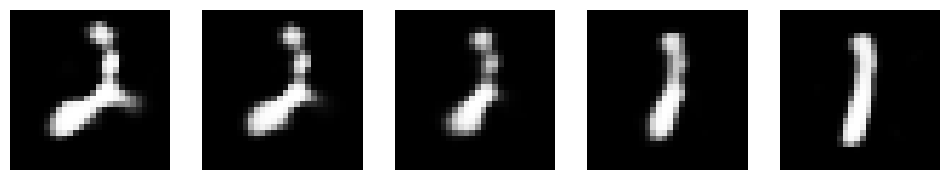

In [53]:
heatmap2d_grid(u_test_decoded)

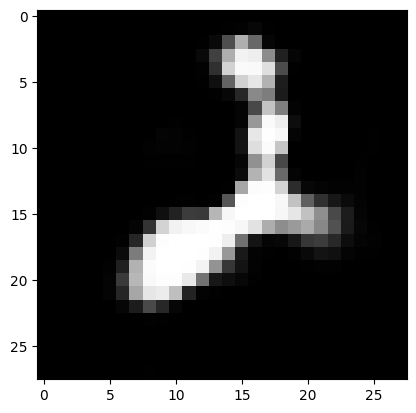

In [54]:
# Produce exact (non-GeONet output) decoded boundary mu_0
u_encoded_section = u0[I,:].cpu().detach().numpy().squeeze() * normalization_constants[I,0] - 10
u_encoded_tf1 = tf.convert_to_tensor(u_encoded_section)
plt.imshow(decoder(tf.expand_dims(u_encoded_tf1,0))[0,:,:], cmap="gray")
#plt.savefig("boundary_MNIST.png", dpi=300)

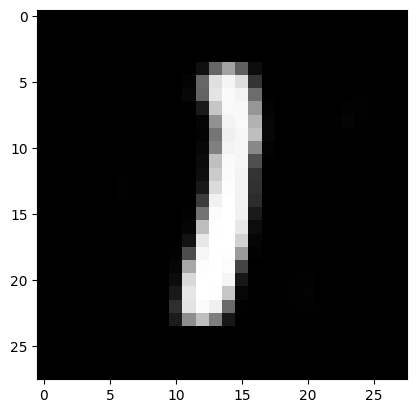

In [55]:
# Produce exact (non-GeONet output) decoded boundary mu_1
u_encoded_section = u1[J,:].cpu().detach().numpy().squeeze() * normalization_constants[J,1] - 10
u_encoded_tf2 = tf.convert_to_tensor(u_encoded_section)
plt.imshow(decoder(tf.expand_dims(u_encoded_tf2,0))[0,:,:], cmap="gray")
#plt.savefig("boundary_MNIST.png", dpi=300)